<br/>

$$ \huge{\underline{\textbf{ On-Policy First-Visit MC Control }}} $$

<br/>

<img src="assets/0504_OnPolicy_MC_Ctrl.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 5.4 </center>

<br/>

In [1]:
def on_policy_MC_control(env, ep, gamma, eps):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor
        eps - epsilon-greedy parameter
    """
    
    def policy(St, pi):
        return np.random.choice(env.act_space, p=[pi[(St,a)] for a in env.act_space])
    
    pi = defaultdict(lambda: 1/env.nb_actions)  # probability of action (def random)
    Q = defaultdict(float)       # default Q value: 0
    Returns = defaultdict(list)  # dict of lists
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy, pi)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
                Returns[(St, At)].append(G)
                Q[(St, At)] = np.average(Returns[(St, At)])
                A_star = argmax_rand([Q[(St,a)] for a in range(env.nb_actions)])  # int
                for a in range(env.nb_actions):
                    if a == A_star:   pi[(St,a)] = 1 - eps + eps/env.nb_actions
                    else:             pi[(St,a)] = eps/env.nb_actions
                        
    return Q, pi

Helper Functions:

In [2]:
def generate_episode(env, policy, *params):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done, _ = env.step(At)
        At = policy(St, *params)        
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

In [3]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

# Alternative Implementation

Problems:
* no need to keep all the returns, just track the sum
* no need to express policy explicitly

In [16]:
def on_policy_MC_control_2(env, ep, gamma, eps):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor
        eps - epsilon-greedy parameter
    """
    
    def policy(St, pi):
        return np.random.choice(env.act_space, p=[pi[(St,a)] for a in env.act_space])
    
    pi = defaultdict(lambda: 1/env.nb_actions)  # probability of action (def random)
    Q = defaultdict(float)        # default Q value: 0
    Counts = defaultdict(int)
    Returns = defaultdict(float)  # stores SUM
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy, pi)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
                Counts[(St, At)]  += 1
                Returns[(St, At)] += G
                Q[(St, At)] = Returns[(St, At)] / Counts[(St, At)]
                A_star = argmax_rand([Q[(St,a)] for a in range(env.nb_actions)])  # int
                for a in range(env.nb_actions):
                    if a == A_star:   pi[(St,a)] = 1 - eps + eps/env.nb_actions
                    else:             pi[(St,a)] = eps/env.nb_actions
                        
    return Q, pi

In [9]:
def on_policy_MC_control_2(env, ep, gamma, eps):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor
        eps - epsilon-greedy parameter
    """
    
    def policy(St, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[(St,a)] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)       # default Q value: 0
    Returns = defaultdict(list)  # dict of lists
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy, Q, eps)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
                Returns[(St, At)].append(G)
                Q[(St, At)] = np.average(Returns[(St, At)])
                A_star = argmax_rand([Q[(St,a)] for a in range(env.nb_actions)])  # int
    
    
    return Q

# Solve Blackjack

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym

In [6]:
env = gym.make('Blackjack-v0')
if not hasattr(env, 'nb_actions'): env.nb_actions = 2
if not hasattr(env, 'act_space'): env.act_space = [0, 1]

In [7]:
from helpers_0504 import plot_blackjack

In [48]:
Q, pi = on_policy_MC_control(env, ep=100000, gamma=1.0, eps=0.1)  # 10+ minutes

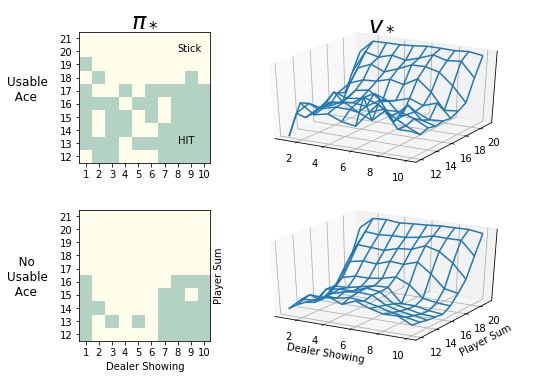

In [15]:
plot_blackjack(Q, pi)

In [49]:
Q, pi = on_policy_MC_control_2(env, ep=100000, gamma=1.0, eps=0.1)  # approx 1 min to run

In [50]:
pi2 = defaultdict(float)
eps = 0.1
for ps in range(12, 22):
    for dc in range(1, 11):
        for ha in [0, 1]:
            for a in range(env.nb_actions):
                St = (ps, dc, ha)
                A_star = argmax_rand([Q[(St,a)] for a in range(env.nb_actions)])  # int
                if a == A_star:   pi2[(St,a)] = 1 - eps + eps/env.nb_actions
                else:             pi2[(St,a)] = eps/env.nb_actions
         

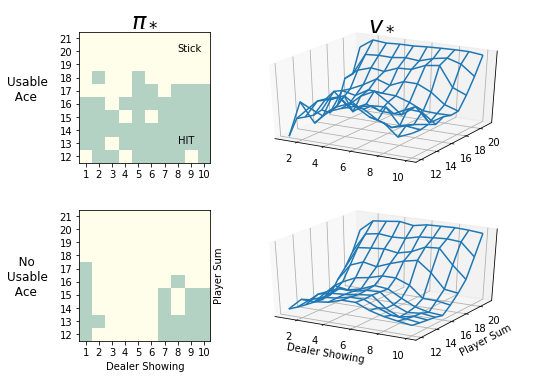

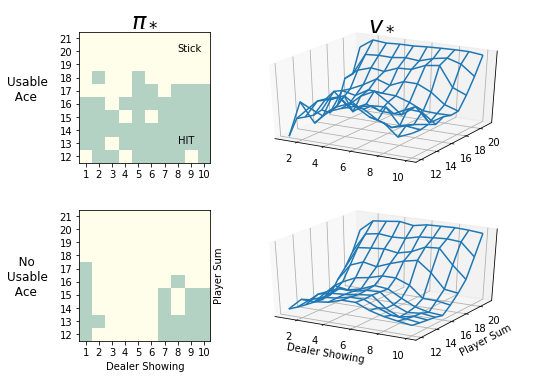

In [52]:
plot_blackjack(Q, pi)
plot_blackjack(Q, pi2)